In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.datasets import *

In [3]:
PATH = Path('/home/jupyter/.fastai/data/pascal/')

In [4]:
trn_j = json.load((PATH/'pascal_train2007.json').open())

In [5]:
IMAGES, TYPE, ANNOTATIONS, CAT = ['images', 'type', 'annotations', 'categories']

In [6]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name', 'id', 'image_id', 'category_id', 'bbox'

In [7]:
cats = {o[ID]:o['name'] for o in trn_j[CAT]}

In [8]:
trn_fns = {o[ID]: o[FILE_NAME] for o in trn_j[IMAGES]}

In [9]:
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [10]:
trn_fns_id = {v:k for k,v in trn_fns.items()}

In [11]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [12]:
def hw_bb(bb):
    return np.array([bb[1], bb[0], bb[1]+bb[3], bb[0]+bb[2]])

In [13]:
trn_anno = collections.defaultdict(lambda: [])

In [14]:
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))

In [15]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key = lambda x:np.product(x[0][-2:] - x[0][:2]), reverse = True)
    return b[0]

In [16]:
trn_lrg_anno = collections.defaultdict(lambda: [])

In [17]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

In [18]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [19]:
def get_bb(f):
    name = lambda x: str(x)[-10:]
    bb = list(trn_lrg_anno[trn_fns_id[name(f)]][0])
    lbl = cats[trn_lrg_anno[trn_fns_id[name(f)]][1]]
    return [[bb],[lbl]]

In [43]:
data = (ObjectItemList.from_csv(PATH, 'tmp/bb.csv', folder = JPEGS)
       .split_by_rand_pct(0.2)
       .label_from_func(get_bb)
       .transform(get_transforms(), resize_method = ResizeMethod.SQUISH, tfm_y = True, size = 224)
       .databunch(bs =16, collate_fn = bb_pad_collate))

In [21]:
head = nn.Sequential(Flatten(), nn.Linear(25088, 4))
learner = cnn_learner(data, models.resnet34, custom_head = head)

In [22]:
def detnloss(input, target, c_t):
    bb_t = target
    bb_i = input[:,None,:]
    bb_i = torch.sigmoid(bb_i)*224
    bb_t = torch.sigmoid(bb_t)*224
    return F.mse_loss(bb_i, bb_t)
    

In [23]:
learner.loss_func = detnloss

In [24]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


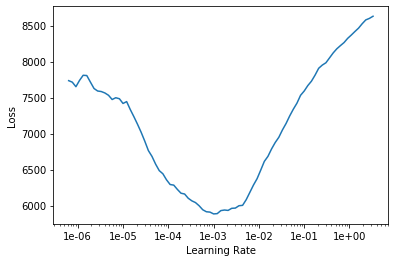

In [25]:
learner.recorder.plot()

In [32]:
learner.fit_one_cycle(3, slice(1e-5))

epoch,train_loss,valid_loss,time
0,2445.030518,2822.686035,00:19
1,2418.332275,2773.504150,00:18
2,2426.536621,2773.057617,00:19


In [27]:
learner.unfreeze()

In [28]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


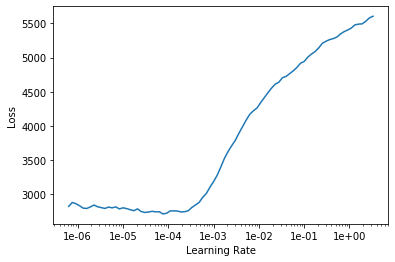

In [29]:
learner.recorder.plot()

In [30]:
learner.fit_one_cycle(5, slice(1e-5))

epoch,train_loss,valid_loss,time
0,2768.205811,3081.085449,00:18
1,2717.639648,2953.134521,00:19
2,2635.235840,2885.469238,00:18
3,2560.812500,2849.210449,00:19
4,2507.593506,2825.327393,00:19


In [31]:
learner.save('bb_mse_v1')

In [33]:
x,y = data.valid_ds[0]

In [60]:
def predbbox(learner,x,y):
    xb,_ = data.one_item(x)
    xb = xb.cuda()
    pred = learner.model(xb)
    predscale = (np.array(pred + 1)*112)
    bbox = ImageBBox.create(224,224, predscale, labels = [0], classes = [''])
    x.show(y=bbox)
    print(f'Predicted is {np.array(pred[0])} and actual is \n{np.array(y.data[0])}')

Predicted is [-0.113915 -1.198821  0.864219  4.872581] and actual is 
[[-0.291291 -1.        1.        0.064   ]]


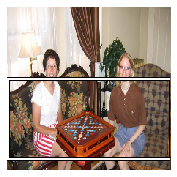

In [61]:
predbbox(learner,x,y)

In [47]:
headnew = nn.Sequential(Flatten(), nn.Linear(25088, 25))

In [48]:
bblbl = cnn_learner(data, models.resnet34, custom_head = headnew )

In [49]:
def detn_loss(input, target, c_t):
    bb_t = target
    bb_i,c_i = input[:,None,:4], input[:,4:]
#    bb_i = torch.sigmoid(bb_i)*224
#    bb_t = torch.sigmoid(bb_t)*224
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t.flatten())*15

In [50]:
bblbl.loss_func = detn_loss

In [25]:
bblbl.load('exp-1')

Learner(data=ImageDataBunch;

Train: LabelList (2001 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/jupyter/.fastai/data/pascal;

Valid: LabelList (500 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/jupyter/.fastai/data/pascal;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 

In [113]:
bblbl.fit_one_cycle(3, slice(1e-4))

epoch,train_loss,valid_loss,time
0,36.815445,21.082582,00:14
1,18.499826,15.596059,00:14
2,12.137438,14.579527,00:15


In [114]:
bblbl.save('exp-1')

In [26]:
bblbl.unfreeze()

In [26]:
bblbl.fit_one_cycle(3, slice(5e-6,3e-5))

epoch,train_loss,valid_loss,time
0,11.333840,11.382136,00:20
1,11.130056,10.810975,00:15
2,9.619850,11.104356,00:15


In [27]:
bblbl.save('unfreeze-exp-1')

In [51]:
bblbl.load('unfreeze-exp-1');

In [78]:
def newpredbbox(learner,x,y):
    xb,_ = data.one_item(x)
    xb = xb.cuda()
    pred = learner.model(xb)
#    pdb.set_trace()
    predbb = pred[0][:4]
    predclass = learner.model(xb)[0][4:]
    predclass = np.array(predclass)
    predclass = np.argmax(predclass)
    predclass = cats[int(predclass)]
    predbbscale = np.array((predbb + 1)*112)
    bbox = ImageBBox.create(224,224, [predbbscale], labels = [0], classes = [str(predclass)])
#    x.show(y=bbox)
    return (predbb,predclass)


In [62]:
bblbl.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


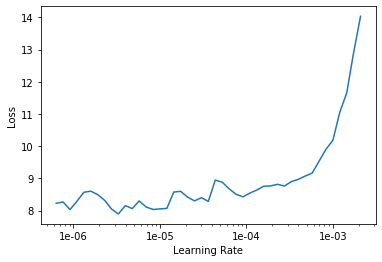

In [63]:
bblbl.recorder.plot()

In [64]:
bblbl.fit_one_cycle(5, slice(5e-6))

epoch,train_loss,valid_loss,time
0,9.152064,6.695797,00:15
1,9.033888,6.868950,00:14
2,9.441583,6.819998,00:15
3,8.877934,6.863081,00:14
4,8.936190,6.680586,00:14


In [65]:
bblbl.save('unfreeze-exp-2')

In [ ]:
fig, axes =  plt.subplots(1,2, figsize = (12,8))
x,y = data.valid_ds[22]
ypred = newpredbbox(bblbl,x,y)
ax 



In [129]:
def predVactual(learner):
    imageint = np.random.randint(0,50)
    x,y = data.valid_ds[imageint]
    #Input will be x and y values. Output will be one image with prediction vs actual bbox
    #will need to get category and bbox of actual
    ybb, yc = y.data
#    pdb.set_trace()
    ybb = np.array(ybb[0])
    ybbscale = list((ybb+1)*112)
    yc = cats[int(yc)]
    #category and bbox of prediction
    predbbox,predclass = newpredbbox(learner,x,y)
    predbbox = np.array(predbbox)
    predbboxscale = list((predbbox+1)*112)
    yypred = [ybbscale,predbboxscale]
    classes = [str(yc),f'Prediction: {predclass}']
    #create new bbox
    bbox = ImageBBox.create(224,224, yypred, labels = [0,1], classes = classes)
    #x.show
    x.show(y=bbox,figsize = (8,6))